# **Statistical Analysis**

## Dependencies and imports

In [1]:
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 171.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 137.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 GB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 207.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 855.3/855.3 kB 213.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 210.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 213.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.

In [ ]:
!pip install networkx matplotlib seaborn pandas kagglehub

ERROR: Invalid requirement: 'networkx,': Expected end or semicolon (after name and no valid version specifier)
    networkx,
            ^


In [1]:
import networkx as nx, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import kagglehub
from collections import Counter
import cugraph as cg
import cudf

## Tabular Twitter Dataset

### Setup

In [20]:
# Download latest version
path = kagglehub.dataset_download("amirhosseinnaghshzan/twitter-2022")

print("Path to dataset files:", path)

100%|██████████| 114M/114M [00:00<00:00, 219MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amirhosseinnaghshzan/twitter-2022/versions/5


In [21]:
tabular_tweets = pd.read_csv(path + '/dataset.csv')

<ipython-input-21-acc9e62a9cb9>:1: DtypeWarning: Columns (5,7,18,21,22,23,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  tabular_tweets = pd.read_csv(path + '/dataset.csv')


In [22]:
# view the dtypes
tabular_tweets.dtypes

,0
url,object
date,object
content,object
likeCount,float64
replyCount,float64
retweetCount,object
viewCount,float64
quoteCount,object
sourceLabel,object
links,object


In [23]:
tabular_tweets.columns

Index(['url', 'date', 'content', 'likeCount', 'replyCount', 'retweetCount',
       'viewCount', 'quoteCount', 'sourceLabel', 'links', 'media',
       'quotedTweet', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
       'cashtags', 'card', 'vibe', 'username', 'UserDescription',
       'UserFavouritesCount', 'followersCount', 'friendsCount', 'location',
       'verified', 'protected', 'mediaCount'],
      dtype='object')

In [24]:
tabular_tweets.head()

,url,date,content,likeCount,replyCount,retweetCount,viewCount,quoteCount,sourceLabel,links,...,vibe,username,UserDescription,UserFavouritesCount,followersCount,friendsCount,location,verified,protected,mediaCount
0,https://twitter.com/LaTera__/status/1477429429...,2022-01-01 23:59:59+00:00,I’m getting a sugar daddy this year!,0.0,10.0,0,210.006559,0,Twitter for iPhone,NaN,...,NaN,LaTera__,NCAT Alumna |🪬 | | For giggles,54402,1955,740,Michigan,False,False,2636.0
1,https://twitter.com/allirica_rose/status/14774...,2022-01-01 23:59:59+00:00,might make em french toast after and spoon a l...,1.0,0.0,0,191.910011,0,Twitter for iPhone,NaN,...,NaN,allirica_rose,"writer, reader, horror lover, general disaster...",12135,65,98,NaN,False,False,375.0
2,https://twitter.com/matrixlms/status/147742942...,2022-01-01 23:59:59+00:00,Our platform can be matched to your company’s ...,0.0,0.0,0,210.006559,0,HubSpot,"[TextLink(text='hubs.ly/Q011g-C00', url='https...",...,NaN,matrixlms,An innovative way to train and learn. \nSign u...,2145,10074,10523,"Plano, TX 75024",False,False,8275.0
3,https://twitter.com/AnarkyIsMe/status/14774294...,2022-01-01 23:59:59+00:00,Oh my God this first song. I can't with how am...,5.0,2.0,0,542.144594,0,Twitter for Android,"[TextLink(text='youtu.be/tA0-WXsm-T0', url='ht...",...,NaN,AnarkyIsMe,Vegan activist trying to make a change in the ...,8130,1507,1092,Earth 🌍,False,False,1760.0
4,https://twitter.com/__amyya/status/14774294292...,2022-01-01 23:59:59+00:00,Happy new year ! 😚🎉,1.0,0.0,0,191.910011,0,Twitter for iPhone,NaN,...,NaN,__amyya,5♥5♥5,39943,590,179,Lost in thought,False,False,625.0


### Hashtag popularity

In [ ]:
all_hashtags = [hashtag.lower() for hashtags_list in tabular_tweets['hashtags'].dropna() for hashtag in eval(hashtags_list)]

In [ ]:
hashtag_counts = Counter(all_hashtags)

In [ ]:
hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count'])

In [ ]:
# make semantic differences for NFTs consistent
hashtag_df = hashtag_df.replace({
    'nfts': 'nft',
    'nftart': 'nft',
    'nftcollector': 'nft',
})

In [ ]:
hashtag_df = hashtag_df.groupby('Hashtag')['Count'].sum().reset_index()

In [ ]:
hashtag_df = hashtag_df.sort_values(by='Count', ascending=False).head(20)
hashtag_df

,Hashtag,Count
8,nft,4090
12,trueachievements,1617
13,twitch,1174
9,nftcommunity,1139
15,vtuber,931
2,bbnaija,841
6,envtuber,647
1,bb24,571
5,crypto,560
0,art,543


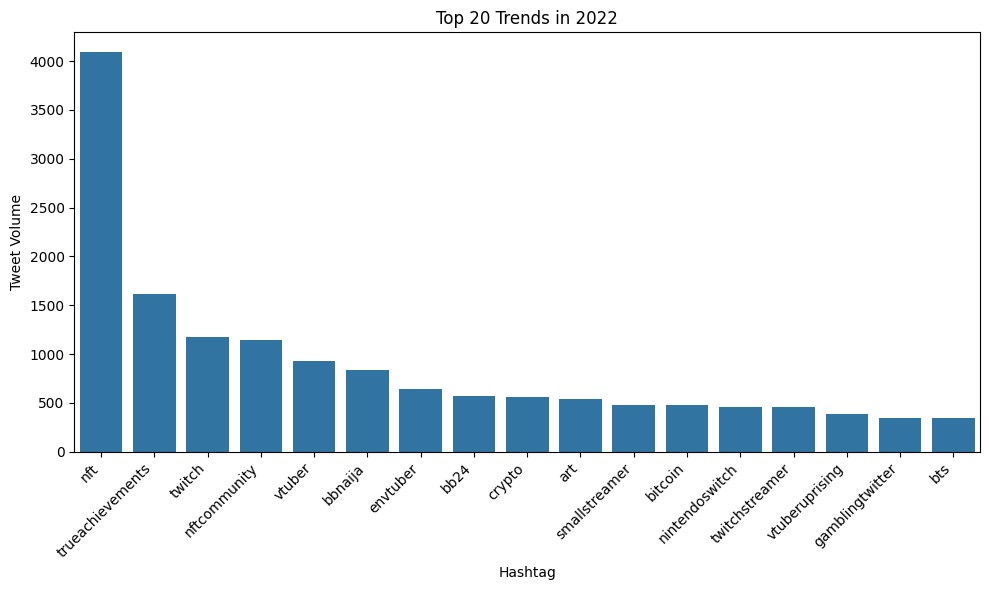

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=hashtag_df, x='Hashtag', y='Count')
plt.xlabel('Hashtag')
plt.ylabel('Tweet Volume')
plt.title('Top 20 Trends in 2022')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Tweeting by location

In [ ]:
import pycountry

# given some location-related text, this function will determine which country the location is most likely a part of
def standardize_country(country_name):
    try:
        country = pycountry.countries.search_fuzzy(country_name)[0]
        return country.name
    except LookupError:
        return country_name

In [ ]:
exploded_data = tabular_tweets.explode('hashtags')  # each hashtag becomes its own row

# count the occurrences of hashtags per location
exploded_data['location'] = exploded_data['location'].str.split(',').str[1]
exploded_data['location'] = exploded_data['location'].str.replace('NJ; New York', 'New York')

In [ ]:
location_counts = exploded_data.groupby('location')['hashtags'].count().reset_index()
location_counts['pycountry_standard'] = location_counts['location'].apply(standardize_country)

In [ ]:
location_counts = location_counts.groupby('pycountry_standard')['hashtags'].sum().reset_index()
location_counts = location_counts.rename(columns={'hashtags': 'Hashtag Count'})

location_counts = location_counts.sort_values(by='Hashtag Count', ascending=False).head(50)

In [ ]:
location_counts_2 = location_counts

In [ ]:
location_counts_2['pycountry_standard'] = location_counts['pycountry_standard'].str.replace('TX', 'Texas')
location_counts_2['pycountry_standard'] = location_counts['pycountry_standard'].str.replace('BC', 'British Columbia')

In [ ]:
location_counts_2

,pycountry_standard,Hashtag Count,Coordinates
9580,United States,5700,"(39.7837304, -100.445882)"
9145,Canada,3851,"(61.0666922, -107.991707)"
9578,United Kingdom,3078,"(54.7023545, -3.2765753)"
5089,Texas,1307,"(31.2638905, -98.5456116)"
9301,Kenya,1204,"(1.4419683, 38.4313975)"
9078,Australia,1021,"(-24.7761086, 134.755)"
9269,Iceland,977,"(64.9841821, -18.1059013)"
9430,Panama,744,"(8.559559, -81.1308434)"
9284,Israel,665,"(30.8124247, 34.8594762)"
9229,Gabon,641,"(-0.8999695, 11.6899699)"


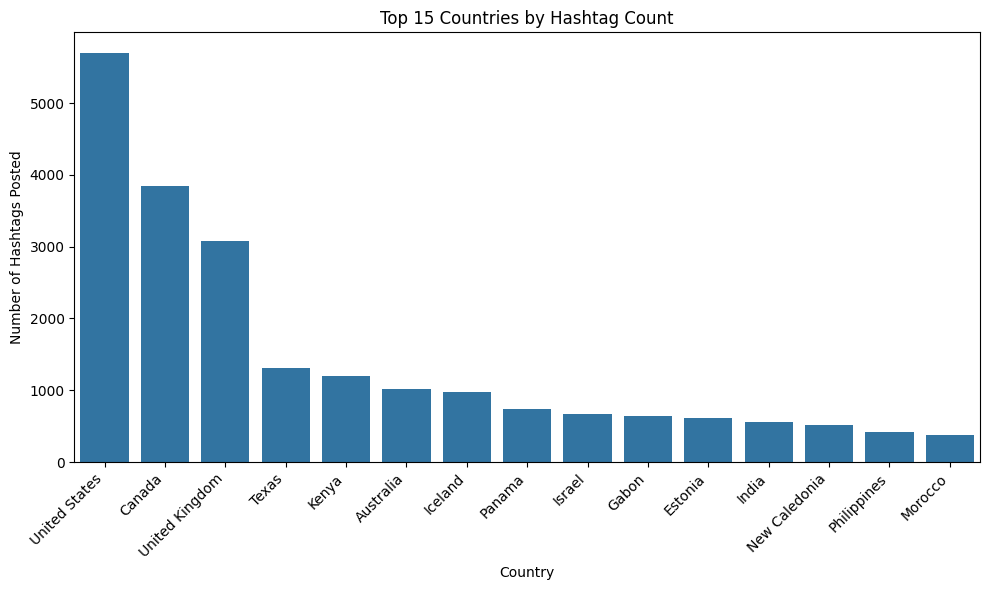

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=location_counts_2.head(15), x='pycountry_standard', y='Hashtag Count', legend=False)
plt.xlabel('Country')
plt.ylabel('Number of Hashtags Posted')
plt.title('Top 15 Countries by Hashtag Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import folium
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap

geolocator = Nominatim(user_agent="location_heatmap")
# get the coordinates for a given location name
def geocode_location(location):
    try:
        loc = geolocator.geocode(location)
        if loc:
            return (loc.latitude, loc.longitude)
    except:
        return None

In [ ]:
location_counts_2['Coordinates'] = location_counts_2['pycountry_standard'].apply(geocode_location)

# filter out rows without valid coordinates - invalid place names
data = location_counts.dropna(subset=['Coordinates'])

In [ ]:
data = location_counts_2.dropna(subset=['Coordinates'])

In [ ]:
# expand hashtags and associate them with their coordinates
exploded_data = data.explode('Hashtag Count')

# prepare data for HeatMap (latitude, longitude, and counts)
heat_data = [
    (coords[0], coords[1])
    for coords in exploded_data['Coordinates']
]

m = folium.Map(location = [54.0, -2.0], zoom_start = 3)
HeatMap(heat_data, radius = 35, blur = 15, min_opacity = 0.6).add_to(m)

m.save('heatmap.html')  # Save the map to view in a browser
m

### Usage by Device

In [ ]:
device_counts = tabular_tweets.dropna(subset='sourceLabel')['sourceLabel'].value_counts()

In [ ]:
top_3 = device_counts.nlargest(3).index

In [ ]:
data_categorized = tabular_tweets.dropna(subset='sourceLabel')['sourceLabel'].apply(lambda x: x if x in top_3 else 'Other')

In [ ]:
device_counts = data_categorized.value_counts()

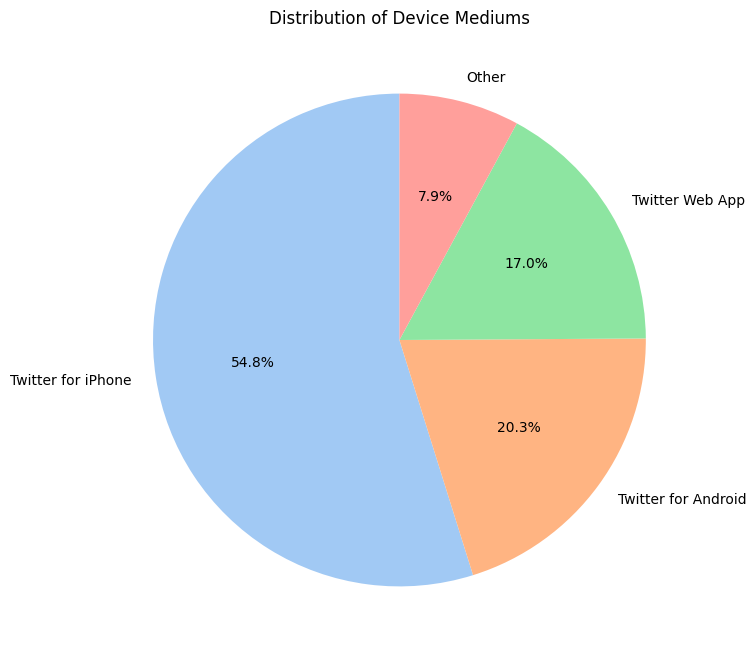

In [ ]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette("pastel")[:len(device_counts)]
plt.pie(device_counts, labels=device_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Device Mediums')
plt.show()

### Most Active Months

In [ ]:
tweet_times = pd.to_datetime(tabular_tweets['date'], errors='coerce')

In [ ]:
month_counts = tweet_times.dt.strftime('%B').value_counts()
month_counts

date
May          46500
October      46499
July         46499
August       46499
March        46498
December     46497
January      46496
June         45000
April        44999
November     44998
September    44997
February     41999
Name: count, dtype: int64

In [ ]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
month_counts = month_counts.reindex(month_order)

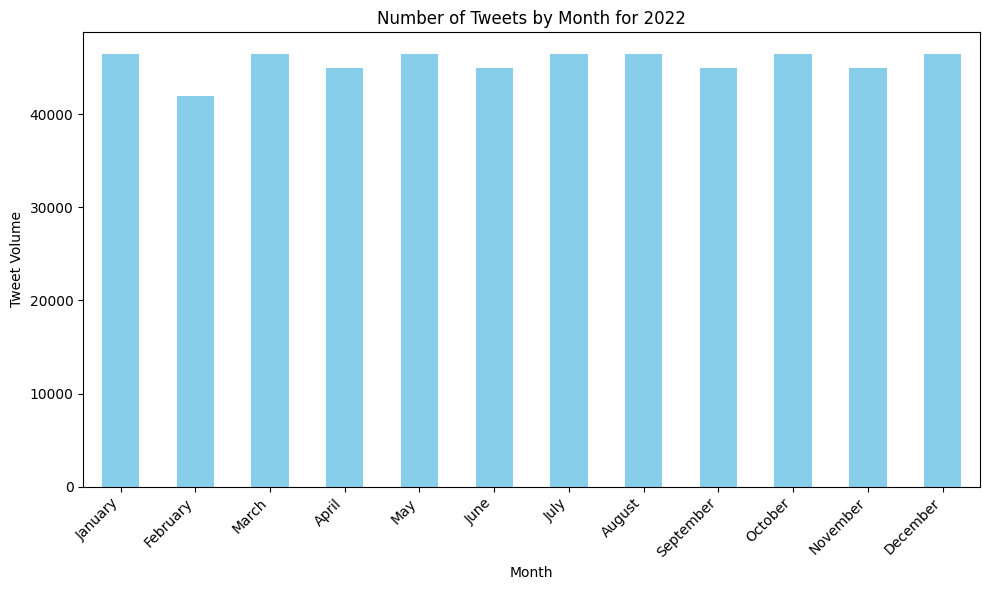

In [ ]:
plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Tweets by Month for 2022')
plt.xlabel('Month')
plt.ylabel('Tweet Volume')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Social Network Graph: Twitter SNAP

In [2]:
!wget https://snap.stanford.edu/data/twitter_combined.txt.gz
!gunzip twitter_combined.txt.gz

--2025-05-27 22:03:12--  https://snap.stanford.edu/data/twitter_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10621918 (10M) [application/x-gzip]
Saving to: ‘twitter_combined.txt.gz’

twitter_combined.tx 100%[===================>]  10.13M  26.9MB/s    in 0.4s    

2025-05-27 22:03:13 (26.9 MB/s) - ‘twitter_combined.txt.gz’ saved [10621918/10621918]



In [4]:
# uses GPU parallel processing by cuGraph to speed up calculations

cu_social_network_graph = cudf.read_csv('twitter_combined.txt', delimiter=' ', names=['source', 'destination'])

cu_graph = cg.from_cudf_edgelist(cu_social_network_graph, source='source', destination='destination')

### Centrality metrics

#### Eigenvector centrality

In [5]:
cu_eigen_centrality = cg.eigenvector_centrality(cu_graph)

/usr/local/lib/python3.11/dist-packages/cugraph/centrality/eigenvector_centrality.py:93: UserWarning: Eigenvector centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


In [15]:
cu_eigen_centrality = cu_eigen_centrality.sort_values('eigenvector_centrality', ascending=False)
cu_eigen_centrality.head(10)

,vertex,eigenvector_centrality
1,40981798,0.172362
3,43003845,0.165223
5,22462180,0.162535
6,34428380,0.162134
43,27633075,0.102091
37,31331740,0.101237
63,83943787,0.093309
47,18996905,0.092844
88,208132323,0.091336
58,117674417,0.088590


#### Degree centrality

In [7]:
cu_deg_centrality = cg.degree_centrality(cu_graph)

In [14]:
cu_deg_centrality = cu_deg_centrality.sort_values('degree_centrality', ascending=False)
cu_deg_centrality.head(10)

,degree_centrality,vertex
0,0.083218,115485051
1,0.079675,40981798
2,0.074067,813286
3,0.067843,43003845
4,0.061251,3359851
5,0.061103,22462180
6,0.060906,34428380
7,0.053010,7861312
8,0.052469,15913
9,0.044007,59804598


#### Between centrality

In [9]:
cu_bet_centrality = cg.betweenness_centrality(cu_graph, k = 1000)

In [13]:
cu_bet_centrality = cu_bet_centrality.sort_values('betweenness_centrality', ascending=False)
cu_bet_centrality.head(10)

,vertex,betweenness_centrality
2,813286,0.062175
0,115485051,0.060170
4,3359851,0.039626
29,15846407,0.033075
1,40981798,0.027694
22,17093617,0.027193
7,7861312,0.022602
70,12925072,0.021829
30,14230524,0.021110
33,62581962,0.018021


#### Most central nodes

In [16]:
top_degree = cu_deg_centrality.head(10)['vertex']
top_betweenness = cu_bet_centrality.head(10)['vertex']
top_eigenvector = cu_eigen_centrality.head(10)['vertex']

In [17]:
# convert to sets so each item is unique, and can apply a simple union-like operation
common_vertices = set(top_degree.to_pandas()) & set(top_betweenness.to_pandas()) & set(top_eigenvector.to_pandas())

print("Common node with high scores across all aforementioned metrics, \nwith respect to each metric:", common_vertices)

Common node with high scores across all aforementioned metrics, 
with respect to each metric: {40981798}


### Graph based on degree centrality

The following code will use 'cugraph' for plotting.

In [18]:
node_sizes = cu_deg_centrality['degree_centrality']*1000

In [23]:
top_nodes = cu_deg_centrality.nlargest(50, 'degree_centrality')['vertex']

In [24]:
top_nodes_set = set(top_nodes.to_pandas())
edges_df = cu_graph.view_edge_list()

subgraph_edges = edges_df[
    edges_df['source'].isin(top_nodes_set) &
    edges_df['destination'].isin(top_nodes_set)
]

# create a subgraph from total nodes
important_subgraph = cg.Graph()
important_subgraph.from_cudf_edgelist(subgraph_edges)

In [25]:
cu_deg_centrality = cudf.DataFrame(cu_deg_centrality)

nodes = important_subgraph.nodes()

node_color = cu_deg_centrality[
    cu_deg_centrality['vertex'].isin(nodes)
]['degree_centrality'].to_pandas().tolist()

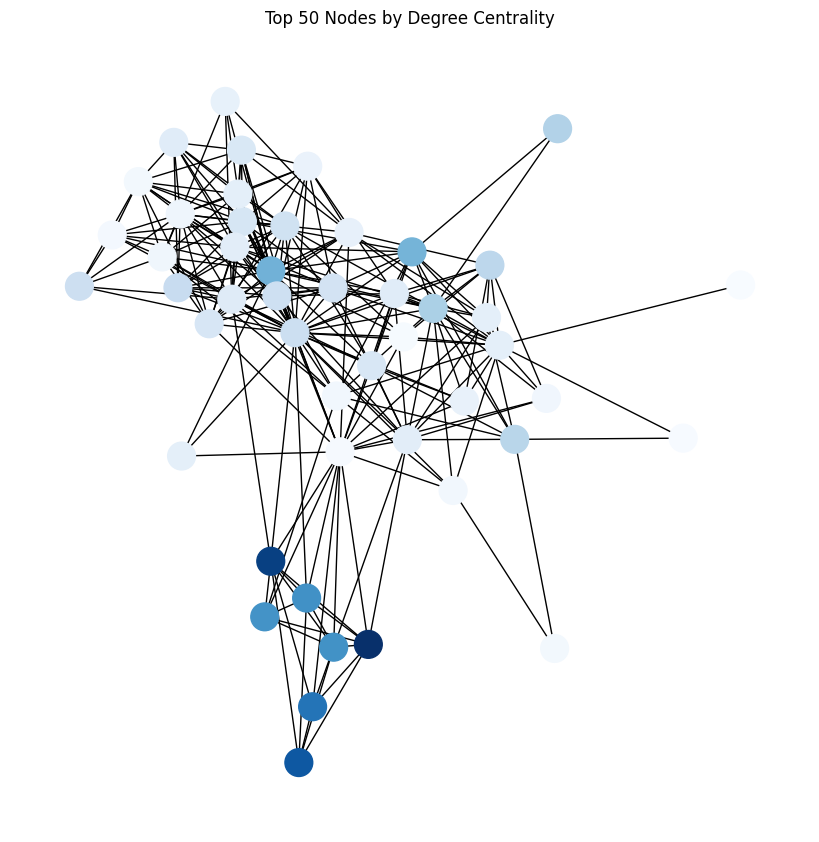

In [28]:
plt.figure(figsize=(8, 8))

# convert to networkx for visualisation
nx_important_subgraph = nx.from_pandas_edgelist(important_subgraph.to_pandas_edgelist(), source = 'source', target = 'destination')

if hasattr(node_color[0], 'get'):
    node_color = [x.get() for x in node_color]
elif isinstance(node_color, cudf.Series):
    node_color = node_color.to_pandas().tolist()

nx.draw(
    nx_important_subgraph,
    with_labels=False,
    node_size=400,
    node_color=node_color,
    cmap=plt.cm.Blues
)

plt.title("Top 50 Nodes by Degree Centrality")
plt.show()

### Community detection

In [5]:
louvain_communities = cg.louvain(cu_graph)

In [10]:
communities, modularity_score = louvain_communities

community_df = cudf.DataFrame(communities, columns=['vertex', 'partition'])

print(f"Modularity Score: {modularity_score}", end = '\n\n')
print(community_df, end = '\n\n')
print("Number of unique communities:", community_df['partition'].nunique())
print("Maximum number of communities:", max(community_df['partition'].value_counts().to_pandas()))

Modularity Score: 0.8042088747024536

          vertex  partition
0      115485051          0
1       40981798          3
2         813286          0
3       43003845          3
4        3359851          1
...          ...        ...
81301  567272538        142
81302  567685433         10
81303  567915211         60
81304  568655523          3
81305  568753458          4

[81306 rows x 2 columns]

Number of unique communities: 164
Maximum number of communities: 10003


In [15]:
community_of_interest = [0, 1, 2]  # communities 1, 2 and 3
max_members_of_community = 100
filtered_nodes = community_df[community_df['partition'].isin(community_of_interest)]

In [16]:
sampled_nodes = (
    filtered_nodes.groupby('partition')
    .apply(lambda group: group.sample(n=min(max_members_of_community, len(group)), random_state=42))
    .reset_index(drop=True)
)['vertex']

In [17]:
edge_df = cu_graph.view_edge_list()

sampled_edges = edge_df[
    edge_df['source'].isin(sampled_nodes) &
    edge_df['destination'].isin(sampled_nodes)
]

sampled_subgraph = nx.from_pandas_edgelist(
    sampled_edges.to_pandas(),
    source='source',  # Note: cugraph uses 'src'/'dst' by default
    target='destination'
)

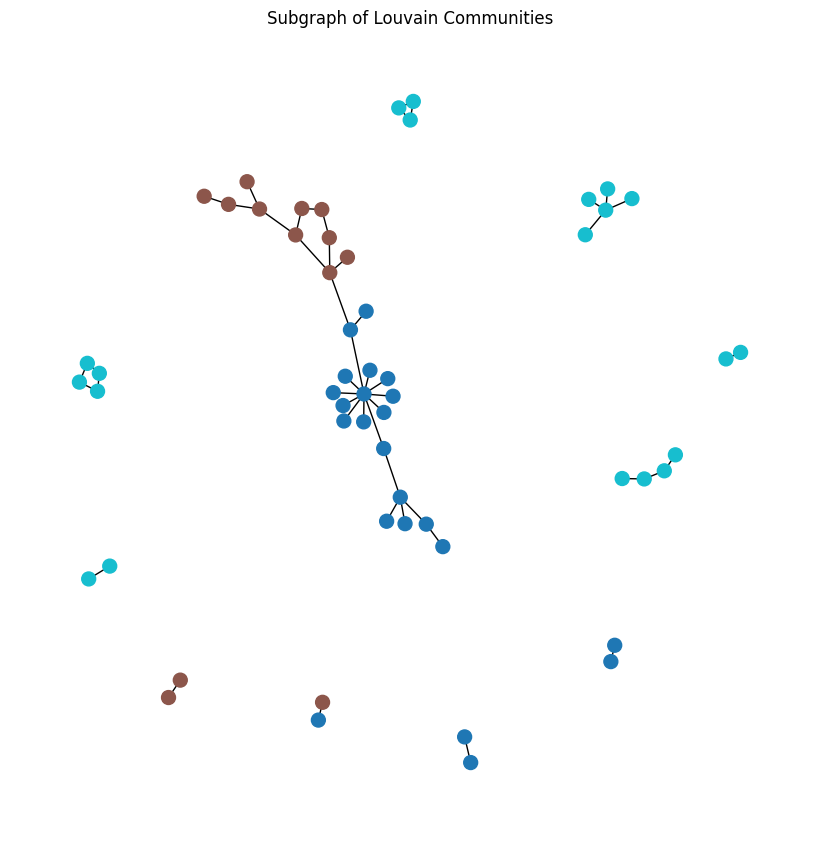

In [19]:
# use the node colors based on communities
node_color = [
    community_df.loc[community_df['vertex'] == node, 'partition'].values[0]
    for node in sampled_subgraph.nodes
]

plt.figure(figsize=(8, 8))
nx.draw(
    sampled_subgraph,
    with_labels=False,
    node_size=100,
    node_color=[x.get() for x in node_color],
    cmap=plt.cm.tab10
)
plt.title("Subgraph of Louvain Communities")
plt.show()

# **Text Mining**

In [1]:
!pip install newsapi-python

In [17]:
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import kagglehub
from textblob import TextBlob
from transformers import pipeline
import requests
from bs4 import BeautifulSoup
from newsapi import NewsApiClient
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
from textwrap import fill
from wordcloud import WordCloud

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Sentiment analysis

### Setup

In [2]:
path = kagglehub.dataset_download("tleonel/cost-of-living")

print("Path to dataset files:", path)

100%|██████████| 23.0M/23.0M [00:01<00:00, 14.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tleonel/cost-of-living/versions/2


In [4]:
cost_of_living_tweets_df = pd.read_csv(path + '/costofliving-query-tweets.csv')

In [6]:
cost_of_living_tweets_df.head(5)

,date_time,username,user_location,user_description,verified,followers_count,following_count,tweet_like_count,tweet_retweet_count,tweet_reply_count,source,tweet_text
0,2022-09-09 00:19:49+00:00,Beer_Enjoyer420,"District of Columbia, USA","I like news, weather, and sports updates! (And...",False,87,270,0,0,0,"<a href=""http://twitter.com/download/android"" ...","""UPS affects virtually every American and here..."
1,2022-09-09 00:19:48+00:00,MLAIrfanSabir,"Calgary, Treaty 7 Territory","The official account of MLA Irfan Sabir, JSS C...",True,7432,854,0,0,0,"<a href=""http://twitter.com/download/iphone"" r...",The UCP is not capable of giving Albertans a c...
2,2022-09-09 00:19:04+00:00,AFDJnews,Australia,ADFJ is your top Australian farming industry n...,False,26,77,0,0,0,"<a href=""https://help.twitter.com/en/using-twi...",Cost of living pushed up by climate-driven flo...
3,2022-09-09 00:18:51+00:00,LitmusTree,Yah Dads House,🇹🇼You looked through my profile after you saw ...,False,56,251,0,0,0,"<a href=""http://twitter.com/download/iphone"" r...",@IIPatricio_ @Askechadd @emexdizzy @twinkbride...
4,2022-09-09 00:18:23+00:00,athenastits,they/them | 18 | uk | leftist,if it's not our flag means death it's the old ...,False,52,154,0,0,0,"<a href=""http://twitter.com/download/android"" ...",there's a massive cost of living crisis in the...


### Experimentation

**Sentiment analysis using TextBlob**

In [29]:
sample_of_tweets_df = cost_of_living_tweets_df.sample(n = 30000)
sample_of_tweets_df = sample_of_tweets_df[['tweet_text']]

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # ranges from -1 (negative) to 1 (positive)

stop_words = set(stopwords.words('english'))

def filter_stopwords(text):
    blob = TextBlob(text)
    extra_stopwords = ['rt', 'https', 'co', 'amp', '&amp;', '...']
    tmp = ' '.join([word for word in blob.words if word.lower() not in stop_words])
    return ' '.join([word for word in tmp.split() if word.lower() not in extra_stopwords])

sample_of_tweets_df['tweet_text'] = sample_of_tweets_df['tweet_text'].apply(filter_stopwords)
sample_of_tweets_df['sentiment'] = sample_of_tweets_df['tweet_text'].apply(get_sentiment)
sample_of_tweets_df = sample_of_tweets_df[['tweet_text', 'sentiment']]

# classify as positive/neutral/negative
sample_of_tweets_df['sentiment_label'] = pd.cut(sample_of_tweets_df['sentiment'],
                              bins=[-1, -0.1, 0.1, 1],
                              labels=['negative', 'neutral', 'positive'])

In [30]:
sample_of_tweets_df.head(5)

,tweet_text,sentiment,sentiment_label
17574,employee benefits could ease cost-of-living bu...,-0.500000,negative
107802,sony increase ps5 price 's 's pure greed know ...,-0.022143,neutral
107371,saidno1evah AdamKinzinger mean like back day p...,-0.006250,neutral
127698,Six million people get £150 cost living paymen...,0.000000,neutral
132930,EmpathyIsBrave RNCResearch aware trump taking ...,0.178571,positive


**Sentiment analysis using a transformer architecture**

In [31]:
transformer_sample_of_tweets_df = cost_of_living_tweets_df.sample(n=30000)

sentiment_pipeline = pipeline("sentiment-analysis",
                              model = "cardiffnlp/twitter-roberta-base-sentiment-latest",
                              truncation = True,
                              max_length = 512) # limit the max token length so that large amounts of text are not attempted to be processed

def transformer_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label'], result['score']

transformer_sample_of_tweets_df[['sentiment_label', 'sentiment_score']] = transformer_sample_of_tweets_df['tweet_text'].apply(
    lambda x: pd.Series(transformer_sentiment(x)))

transformer_sample_of_tweets_df = transformer_sample_of_tweets_df[['tweet_text', 'sentiment_label', 'sentiment_score']]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [32]:
transformer_sample_of_tweets_df

,tweet_text,sentiment_label,sentiment_score
90213,@BtheChngUWt2C @jasonbmartin @GovBillLee Much ...,positive,0.715805
84443,Sign up for a virtual PCS payday rally on the ...,neutral,0.888176
82819,Cost of living: Liz Truss 'rules out' more dir...,negative,0.874106
20336,Cost of living and climate are higher global p...,neutral,0.800343
35665,An immediate option libraries have for helping...,neutral,0.571466
...,...,...,...
117487,Hundreds of people marched in Cape Town as par...,negative,0.590958
120557,Prince Charles has officially confirmed that b...,neutral,0.737347
73934,High net worth brokers and insurers could see ...,neutral,0.666355
89462,Why do these republican congressmen keep assum...,negative,0.838322


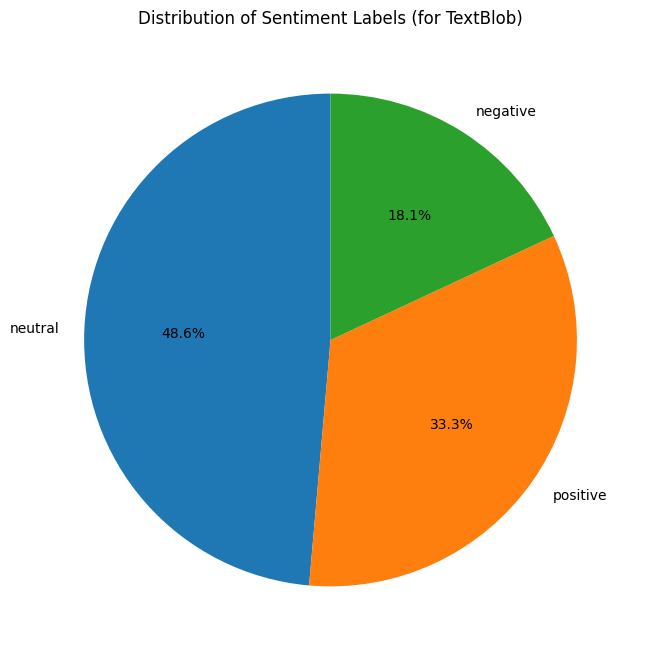

In [35]:
sentiment_counts = sample_of_tweets_df['sentiment_label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiment Labels (for TextBlob)')
plt.show()

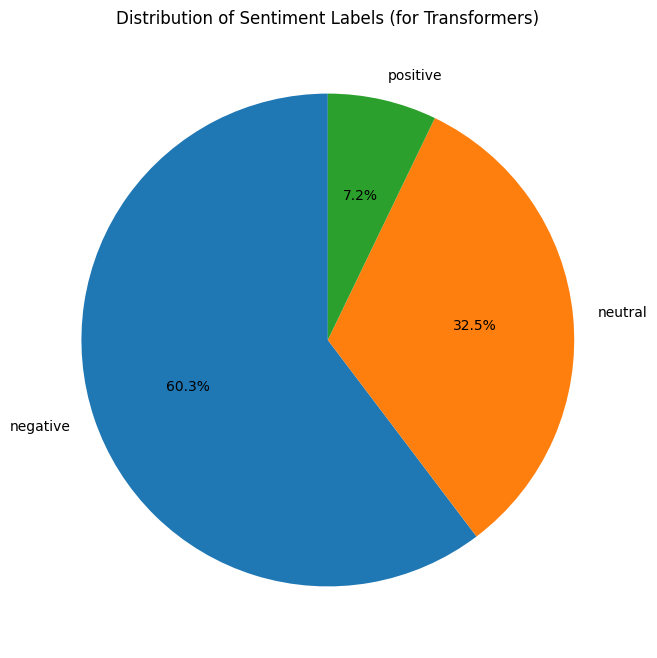

In [36]:
sentiment_counts = transformer_sample_of_tweets_df['sentiment_label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiment Labels (for Transformers)')
plt.show()

### Word clouds

In [27]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

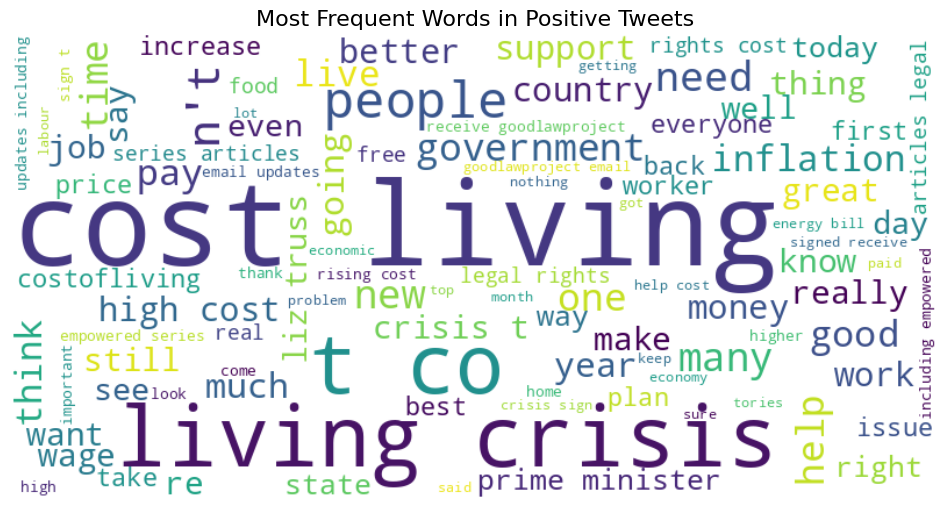

In [41]:
# filter positive tweets
positive_tweets = sample_of_tweets_df[sample_of_tweets_df['sentiment_label'] == 'positive']['tweet_text']

# preprocess text: lowercase, remove stopwords/punctuation
stop_words = set(stopwords.words('english') + ['rt', 'https', 'co', 'amp'])  # common Twitter noise
punctuation = set(string.punctuation)

def preprocess(text):
    words = word_tokenize(text.lower())
    return [word for word in words
            if word not in stop_words
            and word not in punctuation
            and len(word) > 2]

all_positive_words = ' '.join(positive_tweets.apply(preprocess).explode().dropna())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(all_positive_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Tweets', fontsize=16)
plt.show()

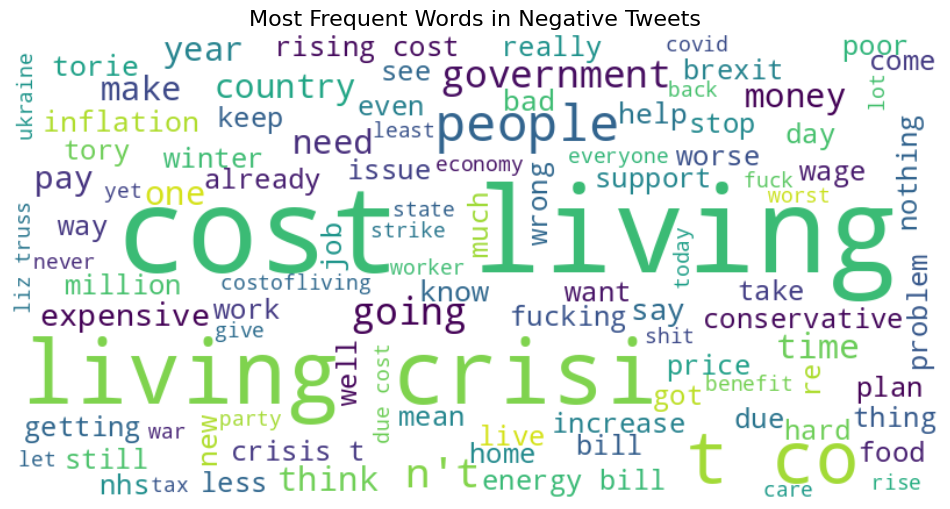

In [44]:
# filter negative tweets
negative_tweets = sample_of_tweets_df[sample_of_tweets_df['sentiment_label'] == 'negative']['tweet_text']

# preprocess text: lowercase, remove stopwords/punctuation
stop_words = set(stopwords.words('english') + ['rt', 'https', 'co', 'amp'])  # common Twitter noise
punctuation = set(string.punctuation)

def preprocess(text):
    words = word_tokenize(text.lower())
    return [word for word in words
            if word not in stop_words
            and word not in punctuation
            and len(word) > 2]

all_negative_words = ' '.join(negative_tweets.apply(preprocess).explode().dropna())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(all_negative_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Tweets', fontsize=16)
plt.show()

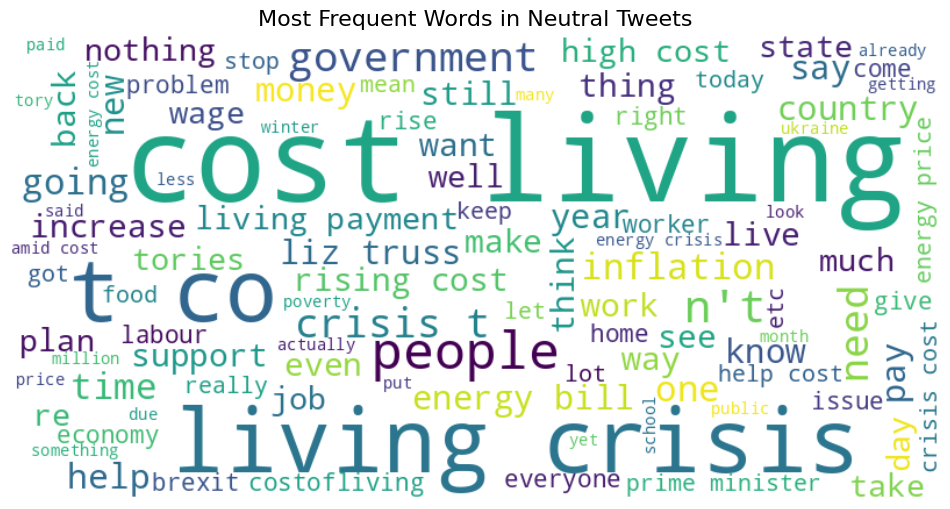

In [45]:
# filter neutral tweets
neutral_tweets = sample_of_tweets_df[sample_of_tweets_df['sentiment_label'] == 'neutral']['tweet_text']

# preprocess text: lowercase, remove stopwords/punctuation
stop_words = set(stopwords.words('english') + ['rt', 'https', 'co', 'amp'])  # common Twitter noise
punctuation = set(string.punctuation)

def preprocess(text):
    words = word_tokenize(text.lower())
    return [word for word in words
            if word not in stop_words
            and word not in punctuation
            and len(word) > 2]

all_neutral_words = ' '.join(neutral_tweets.apply(preprocess).explode().dropna())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(all_neutral_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Neutral Tweets', fontsize=16)
plt.show()

## News Analysis and Topic modelling

In [6]:
news_api = NewsApiClient(api_key = '16d43975850849b89633af7b90a176f2')

In [7]:
results = news_api.get_everything(q = '"cost of living" AND (inflation OR economy)',
                                          sources = 'bbc-news,sky-news,cnn,the-guardian',
                                          from_param = '2025-04-28',
                                          language='en')

articles_df = pd.DataFrame(results['articles'])

Remove any articles with a missing title, description, or content


In [8]:
articles_df = articles_df.dropna(subset=['title', 'description', 'content'])

Remove duplicate titles, descriptions, and contents

In [9]:
articles_df = articles_df.drop_duplicates(subset=['title', 'description', 'content'])

In [10]:
articles_df.shape

(13, 8)

### Summary statistics

In [11]:
# for calculating the mean number of words per article afterwards
total_words = 0
total_sentences = 0

for _, row in articles_df.iterrows():
  article_url = row['url']
  response = requests.get(article_url)
  # retrieve the actual web contents using web scraping
  soup = BeautifulSoup(response.text, "html.parser")
  article_text = soup.get_text()

  sentences = sent_tokenize(article_text)
  words = word_tokenize(article_text)

  # add the actual article words to the relevant dataframe row
  articles_df.loc[articles_df['url'] == article_url, 'article_text'] = article_text
  total_words += len(words)
  total_sentences += len(sentences)

  print(f"TITLE: {row['title']}\nAPPROX. NUM OF SENTENCES: {len(sentences)}\nAPPROX. NUM OF WORDS: {len(words)}\nPUBLISHED; {row['publishedAt']}")
  print('----------------------------')


mean_words = int(total_words / articles_df.shape[0])
mean_sentences = int(total_sentences / articles_df.shape[0])
print(f"Total number of articles: {articles_df.shape[0]}")
print(f"Total number of words: {total_words}")
print(f"Total number of sentences: {total_sentences}")
print(f"Mean number of words per article: {mean_words}")
print(f"Mean number of sentences per article: {mean_sentences}")

TITLE: UK inflation rate jumps to highest in more than a year
APPROX. NUM OF SENTENCES: 19
APPROX. NUM OF WORDS: 1162
PUBLISHED; 2025-05-21T06:01:23Z
----------------------------
TITLE: Inflation news: Prices are falling, but it might be for bad reasons
APPROX. NUM OF SENTENCES: 73
APPROX. NUM OF WORDS: 2195
PUBLISHED; 2025-05-14T09:00:51Z
----------------------------
TITLE: How to trash an economic superpower in 100 days | CNN Business
APPROX. NUM OF SENTENCES: 71
APPROX. NUM OF WORDS: 2231
PUBLISHED; 2025-04-28T20:34:46Z
----------------------------
TITLE: CNN Poll: A growing majority says Trump has made the economy worse, with most skeptical of his tariff plans
APPROX. NUM OF SENTENCES: 60
APPROX. NUM OF WORDS: 2398
PUBLISHED; 2025-04-28T20:00:50Z
----------------------------
TITLE: Inflation surprise suggests outlook could be gloomier than we thought
APPROX. NUM OF SENTENCES: 20
APPROX. NUM OF WORDS: 970
PUBLISHED; 2025-05-21T14:08:11Z
----------------------------
TITLE: Memorial D

### Keyword extraction using TF-IDF

In [12]:
tfidf = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = tfidf.fit_transform(articles_df['description'].str.lower())
top_keywords = tfidf.get_feature_names_out()

print("Top Keywords:", top_keywords)

Top Keywords: ['according' 'americans' 'cnn' 'country' 'donald' 'economic' 'election'
 'federal' 'government' 'inflation' 'liberal' 'march' 'minister' 'party'
 'possible' 'president' 'prices' 'prime' 'remake' 'trump']


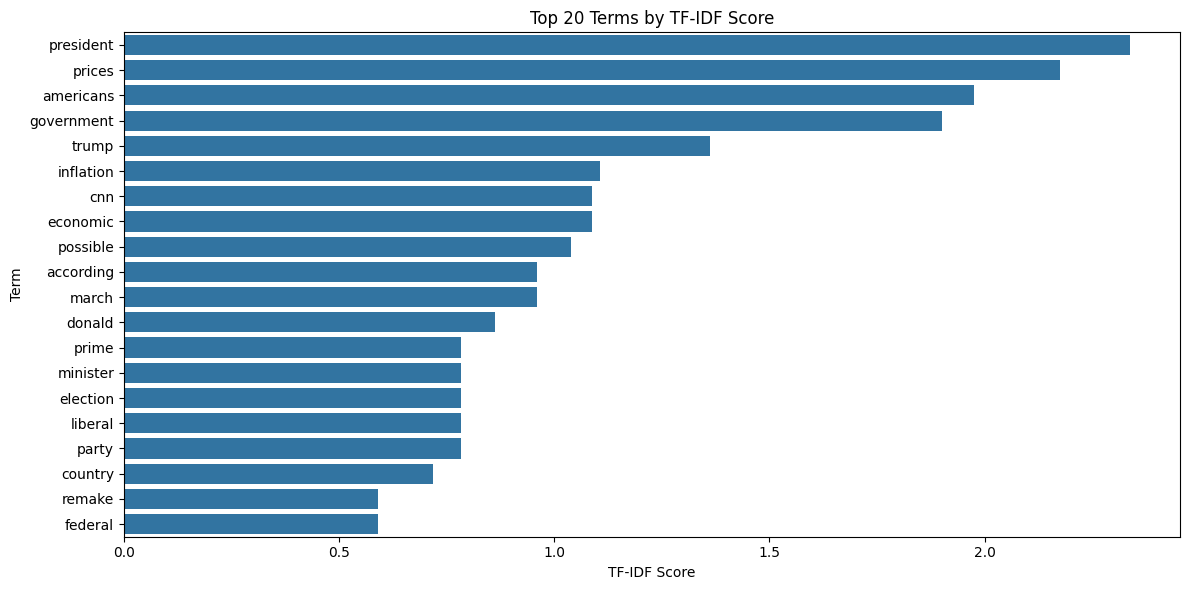

In [13]:
feature_names = tfidf.get_feature_names_out()

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names
)

term_scores = tfidf_df.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=term_scores.values,
    y=term_scores.index,
)
plt.title("Top 20 Terms by TF-IDF Score")
plt.xlabel("TF-IDF Score")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

### Topic Modelling

**Using TF-IDF results and non-negative matrix factorisation (NMF)**

In [14]:
from sklearn.decomposition import NMF

num_topics = 3
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_  # topic-word matrix

In [15]:
feature_names = tfidf.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: possible, remake, trump, president, government
Topic 2: president, possible, inflation, americans, prices
Topic 3: election, minister, party, liberal, prime


Word cloud

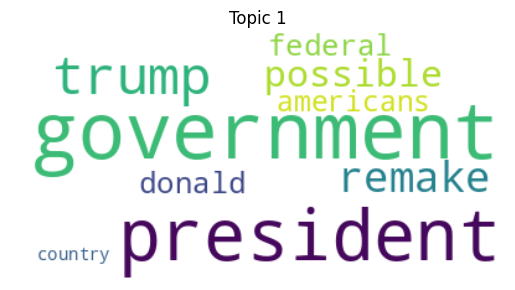

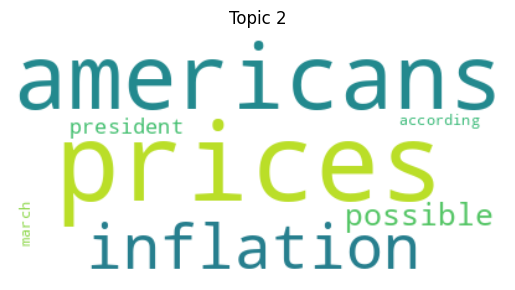

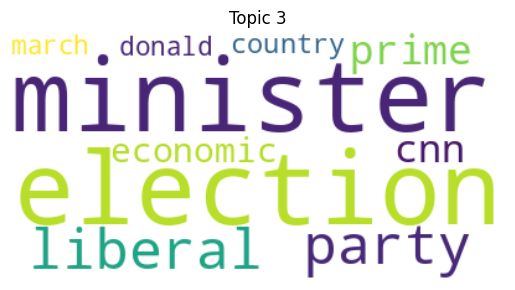

In [18]:
for topic_idx, topic in enumerate(H):
    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[-10:]}  # Top 10 words
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_freq)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()

### Programmatic article summarisation

In [21]:
summarizer = pipeline("summarization", model = "t5-small")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


In [34]:
# selects only BBC articles - CNN ones are structured differently
text = articles_df[articles_df['source'].apply(lambda x: x.get('name', '')) == 'BBC News']['article_text'].iloc[0]
summary = summarizer(text, min_length=30)

In [45]:
original_text = articles_df[articles_df['source'].apply(lambda x: x.get('name', '')) == 'BBC News']['article_text'].iloc[0]
print(fill(f"ARTICLE TITLE: {articles_df[articles_df['source'].apply(lambda x: x.get('name', '')) == 'BBC News']['title'].iloc[0]}", width = 50), end = '\n\n')
print(fill(f"ORIGINAL TEXT: {original_text}", width = 50), end = '\n\n')
print(fill(f"SUMMARY: {summary[0]['summary_text']}", width = 50))

ARTICLE TITLE: UK inflation rate jumps to highest
in more than a year

ORIGINAL TEXT: UK inflation rate rises to highest
in more than a year - BBC NewsBBC HomepageSkip to
contentAccessibility HelpYour accountHomeNewsSport
EarthReelWorklifeTravelCultureFutureMusicTVWeather
SoundsMore menuMore menuSearch BBCHomeNewsSportEar
thReelWorklifeTravelCultureFutureMusicTVWeatherSou
ndsClose menuBBC NewsMenuHomeIsrael-Gaza warWar in
UkraineClimateVideoWorldAsiaUKBusinessTechMoreScie
nceEntertainment & ArtsHealthWorld News TVIn
PicturesBBC VerifyNewsbeatBusinessNew Tech
EconomyTechnology of BusinessArtificial
IntelligencePaths to SuccessBills push inflation
to highest in more than a yearImage source, Getty
ImagesCharlotte EdwardsBusiness reporter, BBC
NewsPublished21 May 20254322 CommentsA rise in the
cost of household bills has pushed UK inflation to
its highest rate in more than a year, according to
official data.Inflation was 3.5% in April, up from
2.6% in March and higher than economists had
e